In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import monai
from pycocotools.coco import COCO
from monai.networks import one_hot
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from pathlib import Path
import cv2
import random
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(2023)

In [3]:
from pathlib import Path
from PIL import Image



data_root = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    """
    A PyTorch Dataset to load data from a json file in COCO format.

    ...
    Attributes
    ----------
    root_dir : str
        the root directory containing the images and annotations
    annotation_file : str
        name of the json file containing the annotations (in root_dir)
    transform : callable
        a function/transform to apply to each image

    Methods
    -------
    __getitem__(idx)
        returns the image, image path, and masks for the given index
    buid_total_mask(masks)
        combines the masks into a single mask
    """


    def __init__(self, root_dir, annotation_file, transform=None, show=False):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.show = show
        self.image_ids = list(self.coco.imgs.keys())
        self.coco_classes = dict([(v["id"], v["name"]) for k, v in self.coco.cats.items()])

        # Filter out image_ids without any annotations
        self.image_ids = [image_id for image_id in self.image_ids if len(self.coco.getAnnIds(imgIds=image_id)) > 0]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = self.root_dir / image_info['file_name']

        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        if self.show:
            plt.subplot(121)
            plt.imshow(image)
            self.coco.showAnns(anns, draw_bbox=True)
            
        bboxes = []
        masks = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h])
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        if self.transform:
            image, masks, bboxes = self.transform(image, masks, np.array(bboxes))

        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)

        if self.show:
            for target in anns:
                image = image.permute(2,1,0).numpy()
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = image * torch.tensor(masks).permute(1,2,0).numpy()
                cv2.rectangle(image, (int(bboxes[0][0]), int(bboxes[0][1])), (int(bboxes[0][2]), int(bboxes[0][3])), (255, 0, 0), 3)
                cv2.putText(image, self.coco_classes[target["category_id"]], (int(bboxes[0][0]), int(bboxes[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0),
                            3)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # print(masks.shape)
            plt.subplot(122)
            plt.imshow(image)
            plt.show()

        return image, torch.tensor(masks).float(), torch.tensor(bboxes).float()

    def get_totalmask(self, masks):
        """get all masks in to one image
        ARGS:
            masks (List[Tensor]): list of masks
        RETURNS:
            total_gt (Tensor): all masks in one image

        """
        total_gt = torch.zeros_like(masks[0][0,:,:])
        for k in range(len(masks[0])):
            total_gt += masks[0][k,:,:]
        return total_gt

In [4]:
class ResizeAndPad:
    """
    Resize and pad images and masks to a target size.

    ...
    Attributes
    ----------
    target_size : int
        the target size of the image
    transform : ResizeLongestSide
        a transform to resize the image and masks
    """

    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, masks, bboxes):
        # Resize image and masks
        og_h, og_w, _ = image.shape
        image = self.transform.apply_image(image)
        masks = [torch.tensor(self.transform.apply_image(mask)) for mask in masks]
        image = self.to_tensor(image)

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = transforms.Pad(padding)(image)
        masks = [transforms.Pad(padding)(mask) for mask in masks]

        # Adjust bounding boxes
        bboxes = self.transform.apply_boxes(bboxes, (og_h, og_w))
        bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]

        return image, masks, bboxes

In [5]:
train_root = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\train'
train_anno = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\train\_annotations.coco.json'

valid_root = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid'
valid_anno = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid\_annotations.coco.json'

def load_datasets(img_size):
    """ load the training and validation datasets in PyTorch DataLoader objects
    ARGS:
        img_size (Tuple(int, int)): image size
    RETURNS:
        train_dataloader (DataLoader): training dataset
        val_dataloader (DataLoader): validation dataset

    """
    transform = ResizeAndPad(img_size)
    traindata = NpzDataset(root_dir=train_root,
                           annotation_file=train_anno,
                           transform=transform)
    valdata = NpzDataset(root_dir=valid_root,
                         annotation_file=valid_anno,
                         transform=transform)
    train_dataloader = DataLoader(traindata,
                                  batch_size=1,
                                  shuffle=True)
    val_dataloader = DataLoader(valdata,
                                batch_size=1)
    return train_dataloader, val_dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


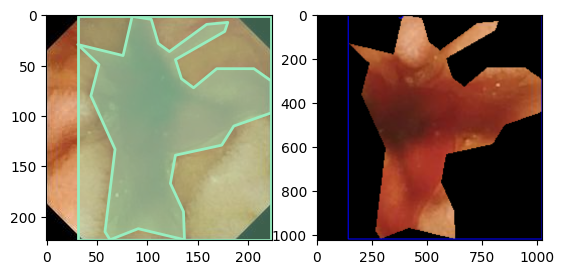

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [6]:
transform = ResizeAndPad(1024)
traindata = NpzDataset(root_dir=train_root,
                        annotation_file=train_anno,
                        transform=transform,
                        show=True)
traindata[0][1]

In [7]:
trainloader, validloader = load_datasets(1024)
sample_img = trainloader.dataset[0][0]
sample_mask = trainloader.dataset[0][1]
sample_bbox = trainloader.dataset[0][2]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
trainloader.dataset[0][0].shape,trainloader.dataset[0][1].shape,trainloader.dataset[0][2].shape

(torch.Size([3, 1024, 1024]), torch.Size([1, 1024, 1024]), torch.Size([1, 4]))

In [9]:
print(f'shape of sample_img: {sample_img.shape}')
print(f'shape fo sample_mask: {sample_mask.shape}')
print(f'shape fo sample_mask: {sample_bbox.shape}')

shape of sample_img: torch.Size([3, 1024, 1024])
shape fo sample_mask: torch.Size([1, 1024, 1024])
shape fo sample_mask: torch.Size([1, 4])


In [10]:
# train_vis = Path(r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\train\vis')
# train_vis.mkdir(parents=True, exist_ok=True)
# import matplotlib.style as mplstyle
# mplstyle.use('fast')
# for i in tqdm(range(len(trainloader.dataset))):
#     sample_img = trainloader.dataset[i][0]
#     sample_mask = trainloader.dataset[i][1]
#     plt.subplot(121)
#     plt.axis(False)
#     plt.imshow(sample_img.permute(2,1,0))

#     plt.subplot(122)
#     plt.axis(False)
#     plt.imshow(sample_mask.permute(2,1,0))

#     plt.savefig(train_vis/f'{i}.png')

#     plt.clf()

In [11]:
work_dir = Path(r'D:\Side_project\MedSAM\ipynbs\finetunesam')
task_name = 'finetune_4'
model_type = 'vit_b'
checkpoint = r'D:\Side_project\MedSAM\work_dir\MedSAM\medsam_vit_b.pth'
device = 'cuda'

model_save_path:Path = work_dir / task_name
model_save_path.mkdir(parents=True, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)

In [12]:
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [13]:
#%% train
from timeit import default_timer as timer
num_epochs = 30
losses = []
best_loss = 1e10

start_time = timer()
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (img, mask, boxes) in enumerate(tqdm(trainloader)):
        img, mask, boxes = map(lambda x: x.to(device), [img, mask, boxes])
        # print(boxes.shape)

        # predicted masks
        for param in sam_model.image_encoder.parameters():
            param.requires_grad = False
        for param in sam_model.prompt_encoder.parameters():
            param.requires_grad = False

        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            # box_np = boxes.numpy()
            # sam_trans = ResizeLongestSide(sam_wapper.sam_model.image_encoder.img_size)
            # box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            # box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=boxes,
                masks=None,
            )

        img = img.to(device)

        image_embeddings = sam_model.image_encoder(img)
        # print(f'{image_embeddings.shape=}')

        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embeddings.to(device), # (B, 256, 64, 64) (B, C, H, W)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64) (B, C, H, W)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64) (B, C, H, W)
            multimask_output=False,
          )

        pred_shapped_masks = F.interpolate(
            mask_predictions, # shape: (1, 1, 256, 256)
            (img.shape[-2], img.shape[-1]),
            mode="bilinear",
            align_corners=False,
        )

        loss = seg_loss(pred_shapped_masks, mask.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), (model_save_path / f'sam_model_best_epoch={epoch}_loss={best_loss:.3f}.pth'))

    torch.save(sam_model.state_dict(), (model_save_path / f'sam_model_epoch={epoch}_loss={best_loss:.3f}.pth'))
end_time = timer()

print(f'Training time: {end_time - start_time:.3f}')

100%|██████████| 1038/1038 [05:23<00:00,  3.21it/s]


EPOCH: 0, Loss: 0.3456493349621933


100%|██████████| 1038/1038 [05:30<00:00,  3.14it/s]


EPOCH: 1, Loss: 0.2994305832686914


100%|██████████| 1038/1038 [05:29<00:00,  3.15it/s]


EPOCH: 2, Loss: 0.28147151231004164


100%|██████████| 1038/1038 [05:30<00:00,  3.14it/s]


EPOCH: 3, Loss: 0.2680873042556278


100%|██████████| 1038/1038 [05:30<00:00,  3.14it/s]


EPOCH: 4, Loss: 0.2565877652630971


100%|██████████| 1038/1038 [05:34<00:00,  3.10it/s]


EPOCH: 5, Loss: 0.24753168943762893


100%|██████████| 1038/1038 [05:31<00:00,  3.13it/s]


EPOCH: 6, Loss: 0.23873276779699348


100%|██████████| 1038/1038 [05:29<00:00,  3.15it/s]


EPOCH: 7, Loss: 0.23167218575065482


100%|██████████| 1038/1038 [05:28<00:00,  3.16it/s]


EPOCH: 8, Loss: 0.22474233629388543


100%|██████████| 1038/1038 [05:27<00:00,  3.17it/s]


EPOCH: 9, Loss: 0.21754658035754354


100%|██████████| 1038/1038 [06:28<00:00,  2.67it/s]


EPOCH: 10, Loss: 0.21277796762673007


 85%|████████▌ | 883/1038 [04:45<00:50,  3.05it/s]

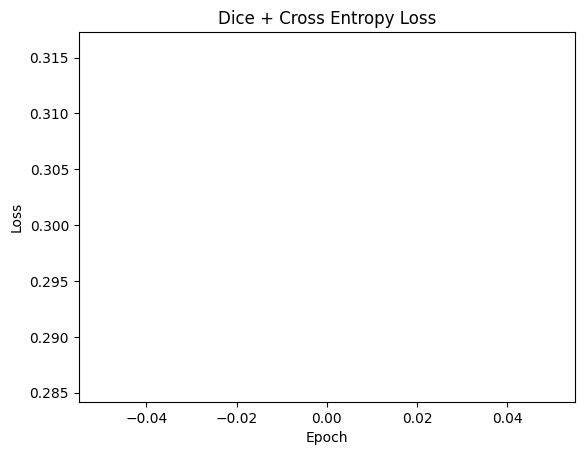

In [ ]:
# # plot loss
# plt.plot(losses)
# plt.title('Dice + Cross Entropy Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show() # comment this line if you are running on a server
# # plt.savefig((model_save_path / 'train_loss.png'))
# plt.close()

In [ ]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
# from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

image_id = 0
root_dir = Path(r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid')
anno_info = COCO(r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid\_annotations.coco.json')
image_info = anno_info.loadImgs(image_id)[0]
image_path = root_dir / image_info['file_name']
ann_ids = anno_info.getAnnIds(imgIds=image_id)
anns = anno_info.loadAnns(ann_ids)

mask = anno_info.annToMask(anns[0])
# print(mask)
# for ann in anns:
#     mask = anno_info.annToMask(ann)
#     masks.append(mask)

# random select a test case
# img_idx = np.random.randint(len(test_names))
image_data = np.array(Image.open(root_dir / image_info['file_name']))
# if image_data.shape[-1]>3 and len(image_data.shape)==3:
#     image_data = image_data[:,:,:3]
# if len(image_data.shape)==2:
#     image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(1, x_min - np.random.randint(0, 20))
    x_max = min(W-1, x_max + np.random.randint(0, 20))
    y_min = max(1, y_min - np.random.randint(0, 20))
    y_max = min(H-1, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

# gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
bbox_raw = get_bbox_from_mask(mask)
print(f'{bbox_raw=}')


# # preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
bbox_raw=array([ 58,  51, 210, 223], dtype=int64)


In [ ]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
checkpoint_gas = r'D:\Side_project\MedSAM\ipynbs\finetunesam\finetune_4\sam_model_best.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint_gas).to(device)
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
# print(resize_img.shape)
# plt.imshow(resize_img)

resize_img_tensor = transforms.ToTensor()(resize_img).to(device)
# print(resize_img_tensor.shape)
# resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)

input_image = sam_model.preprocess(resize_img_tensor.unsqueeze(dim=0)) # (1, 3, 1024, 1024)
# assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    bbox = sam_transform.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)

    pred_shapped_masks = F.interpolate(
        medsam_seg_prob, # shape: (1, 1, 256, 256)
        (224, 224),
        mode="bilinear",
        align_corners=False,
    )

    # convert soft mask to hard mask
    pred_shapped_masks = pred_shapped_masks.cpu().numpy().squeeze()
    medsam_seg = (pred_shapped_masks > 0.5).astype(np.uint8)



bbox_raw=array([ 58,  51, 210, 223], dtype=int64) -> bbox=array([[ 265.14285714,  233.14285714,  960.        , 1019.42857143]])
(224, 224)


In [ ]:
ori_sam_dsc = compute_dice_coefficient(mask>0, ori_sam_seg>0)
medsam_dsc = compute_dice_coefficient(mask>0, medsam_seg>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.6620 MedSAM DSC: 0.6157


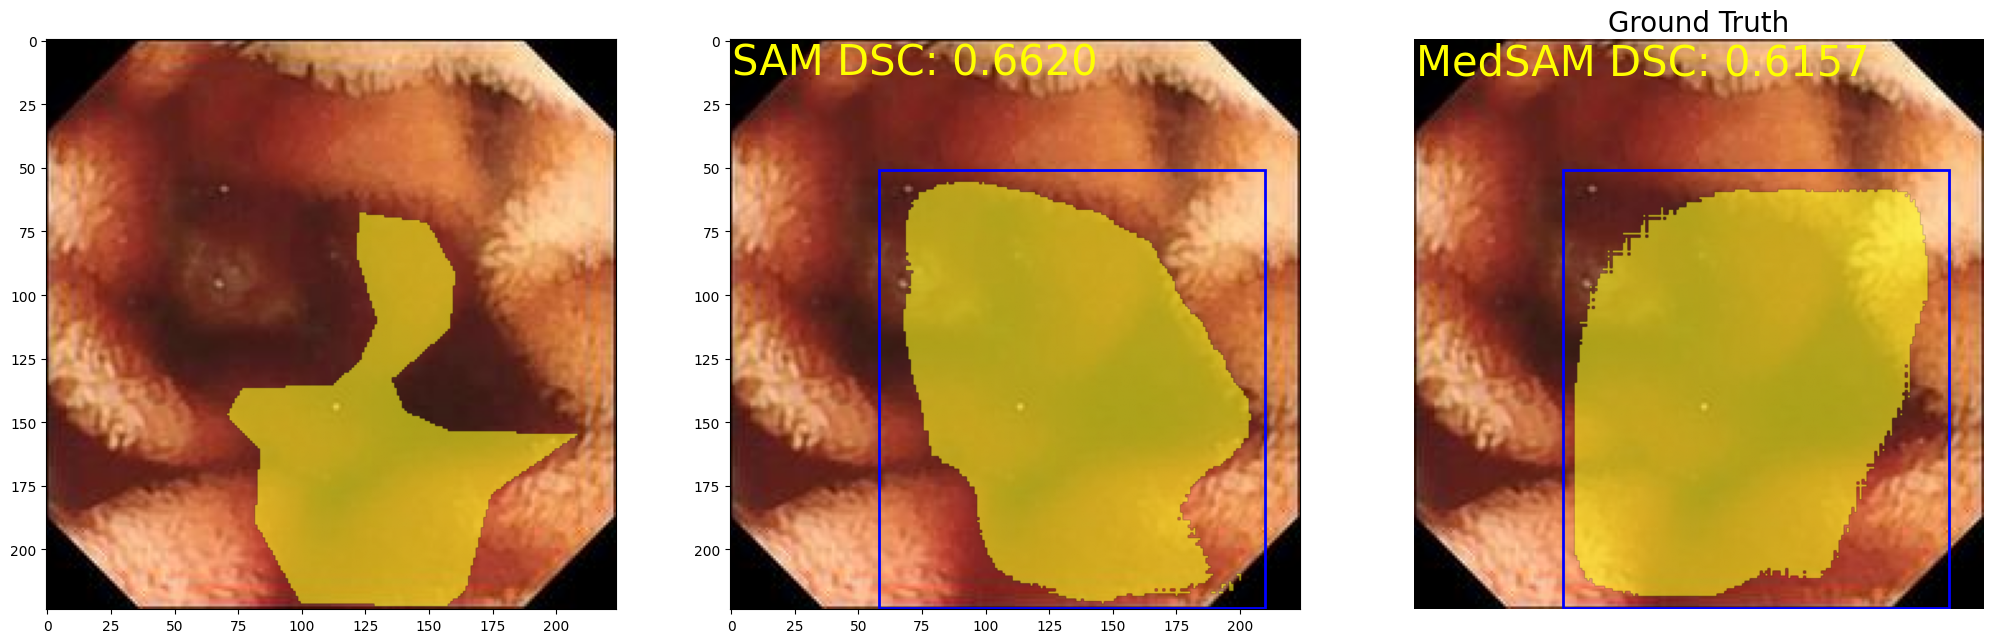

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(mask>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
# axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# # add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
# axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
# # add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
# plt.subplots_adjust(wspace=0.01, hspace=0)
# # save plot
# # plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()